In [1]:
import os, sys
import numpy as np
import pandas as pd
import numba

import sklearn
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rc('text', usetex=True)

import time, datetime
import itertools
from joblib import Parallel, delayed
import pickle

In [2]:
data_name = 'alpha'

network_df = pd.read_csv('../rev2data/%s/%s_network.csv' %(data_name, data_name), header=None, names=['src', 'dest', 'rating', 'timestamp'], parse_dates=[3], infer_datetime_format=True)

user_list = ['u' + str(u) for u in network_df['src'].tolist()]

gt_df = pd.read_csv('../rev2data/%s/%s_gt.csv' %(data_name, data_name), header=None, names=['id', 'label'])
gt = dict([('u'+str(x[0]), x[1]) for x in zip(gt_df['id'], gt_df['label'])])

In [3]:
# alg_list = ['bad', 'bn', 'rev2', 'trust', 'fraudar', 'rsd']
alg_list = ['bad', 'bn', 'rev2', 'trust', 'fraudar']

alg_res = {alg_name: pickle.load(open('../res/%s/%s.pkl' %(alg_name, data_name), 'rb')) for alg_name in alg_list}

## Metrics grid, top measures @`q`, where `q` is in the range from 2% to 20%
+ precision
+ recall
+ f1 score


In [4]:
q = np.arange(2, 22, 2)/100

def get_metrics(ytrue, yscore):
    '''get precision and recall at q percentile'''
    assert len(ytrue) == len(yscore)
    size = len(ytrue)
    prec_dict = {}
    recl_dict = {}
    f1_dict = {}
    for qq in q:
        cut = qq*size
        ypred = (np.arange(size) < cut) * 1
        prec = sklearn.metrics.precision_score(y_pred=ypred, y_true=ytrue)
        recl = sklearn.metrics.recall_score(y_pred=ypred, y_true=ytrue)
        f1 = sklearn.metrics.f1_score(y_pred=ypred, y_true=ytrue)
        prec_dict[qq] = prec
        recl_dict[qq] = recl
        f1_dict[qq] = f1
    return prec_dict, recl_dict, f1_dict

def compute_metrics(alg_name, k, n, ind):
    ulist = np.array(alg_res[alg_name][(k, n, ind)]['ulist'])
    yscore = np.array(alg_res[alg_name][(k, n, ind)]['yscore'])
    ytrue = np.array(alg_res[alg_name][(k, n, ind)]['ytrue'])
    prec_dict, recl_dict, f1_dict = get_metrics(ytrue, yscore)
    return {'prec': prec_dict, 'recl': recl_dict, 'f1': f1_dict}

In [5]:
restart = True
n_cores = 6

pkl_path = '../res/%s.pkl' %data_name

if os.path.exists(pkl_path) and not restart:
    with open(pkl_path, 'rb') as f: metrics_dict = pickle.load(f)
    print('load from %s' %pkl_path)
else:
    print('compute from scratch')
    metrics_dict = {alg_name: Parallel(n_jobs=n_cores, verbose=5)(delayed(compute_metrics)(alg_name, k, n, ind) for k, n, ind in itertools.product(range(11), range(11), range(50))) for alg_name in alg_list}
    with open(pkl_path, 'wb') as f: pickle.dump(metrics_dict, f)
    print('save to %s' %pkl_path)

compute from scratch


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    8.3s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   12.6s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   19.7s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   29.1s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   41.0s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:   55.9s
[Parallel(n_jobs=6)]: Done 870 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 1446 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 2166 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 2580 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 3030 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 3516 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:  5.0min
[P

save to ../res/alpha.pkl


In [6]:
met_list = ['prec', 'recl', 'f1']

# plot_data_dict = {alg_name: {m: {} for m in met_list} for alg_name in alg_list}

plot_data_dict ={alg_name: dict(zip(itertools.product(range(11), range(11), range(50)), metrics_dict[alg_name])) for alg_name in alg_list}

In [7]:
# color_map = {alg_list[i]: plt.cm.tab10(i) for i in range(len(alg_list))}
color_map = {alg_list[i]: 'C%d' %i for i in range(len(alg_list))}

def plot_lines(ax, x, y_data, ylabel='', xlabel='', title='', e_data=None):
    lines = []
    for alg_name in alg_list:
        y = y_data[alg_name]
        lines += [ax.plot(x, y, marker='x', color=color_map[alg_name])[0]]
        if e_data != None:
            e = e_data[alg_name]
            ax.errorbar(x, y, e, linestyle='None', capsize=2, color=color_map[alg_name])
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_title(title, fontsize=13)
    return lines

## Plot precision for each k,n pair

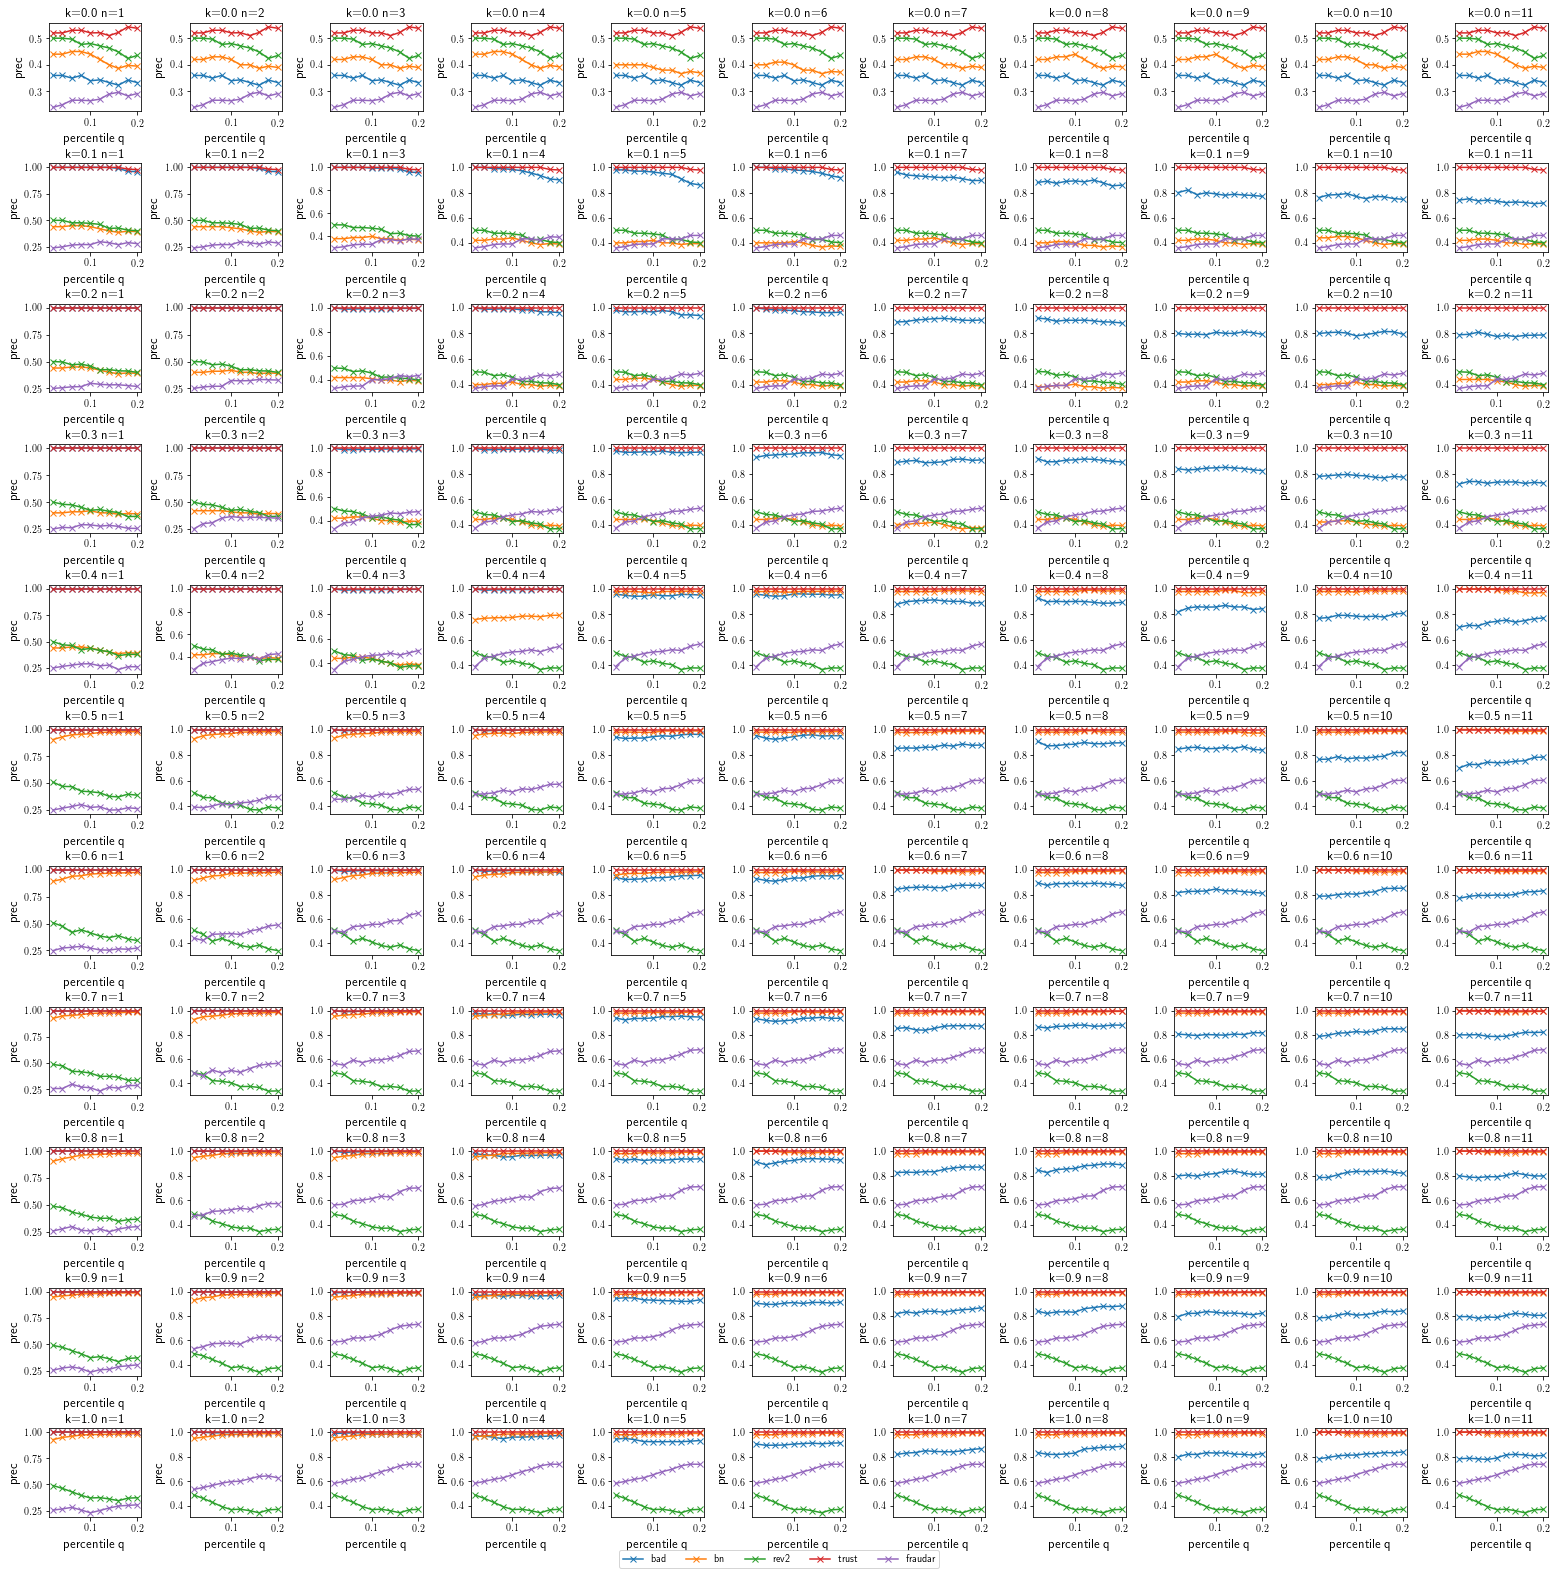

In [8]:
fig_prec, axes = plt.subplots(11, 11, figsize=(22, 22))
m = 'prec'

for k, n in itertools.product(range(11), range(11)):
    y_data = {}
    for alg_name in alg_list:
        y_data[alg_name] = [np.mean([plot_data_dict[alg_name][(k, n, ind)][m][qq] for ind in range(50)]) for qq in q]
    lines = plot_lines(axes[k, n], q, y_data, xlabel='percentile q', ylabel=m, title='k=%.1f n=%d' %(k/10, n+1), e_data=None)
    
fig_prec.tight_layout(pad=2, w_pad=0.3, h_pad=0.2)
fig_prec.legend(lines, alg_list, loc='lower center', ncol=len(alg_list), fontsize='medium')

## Plot recall for each k,n pair

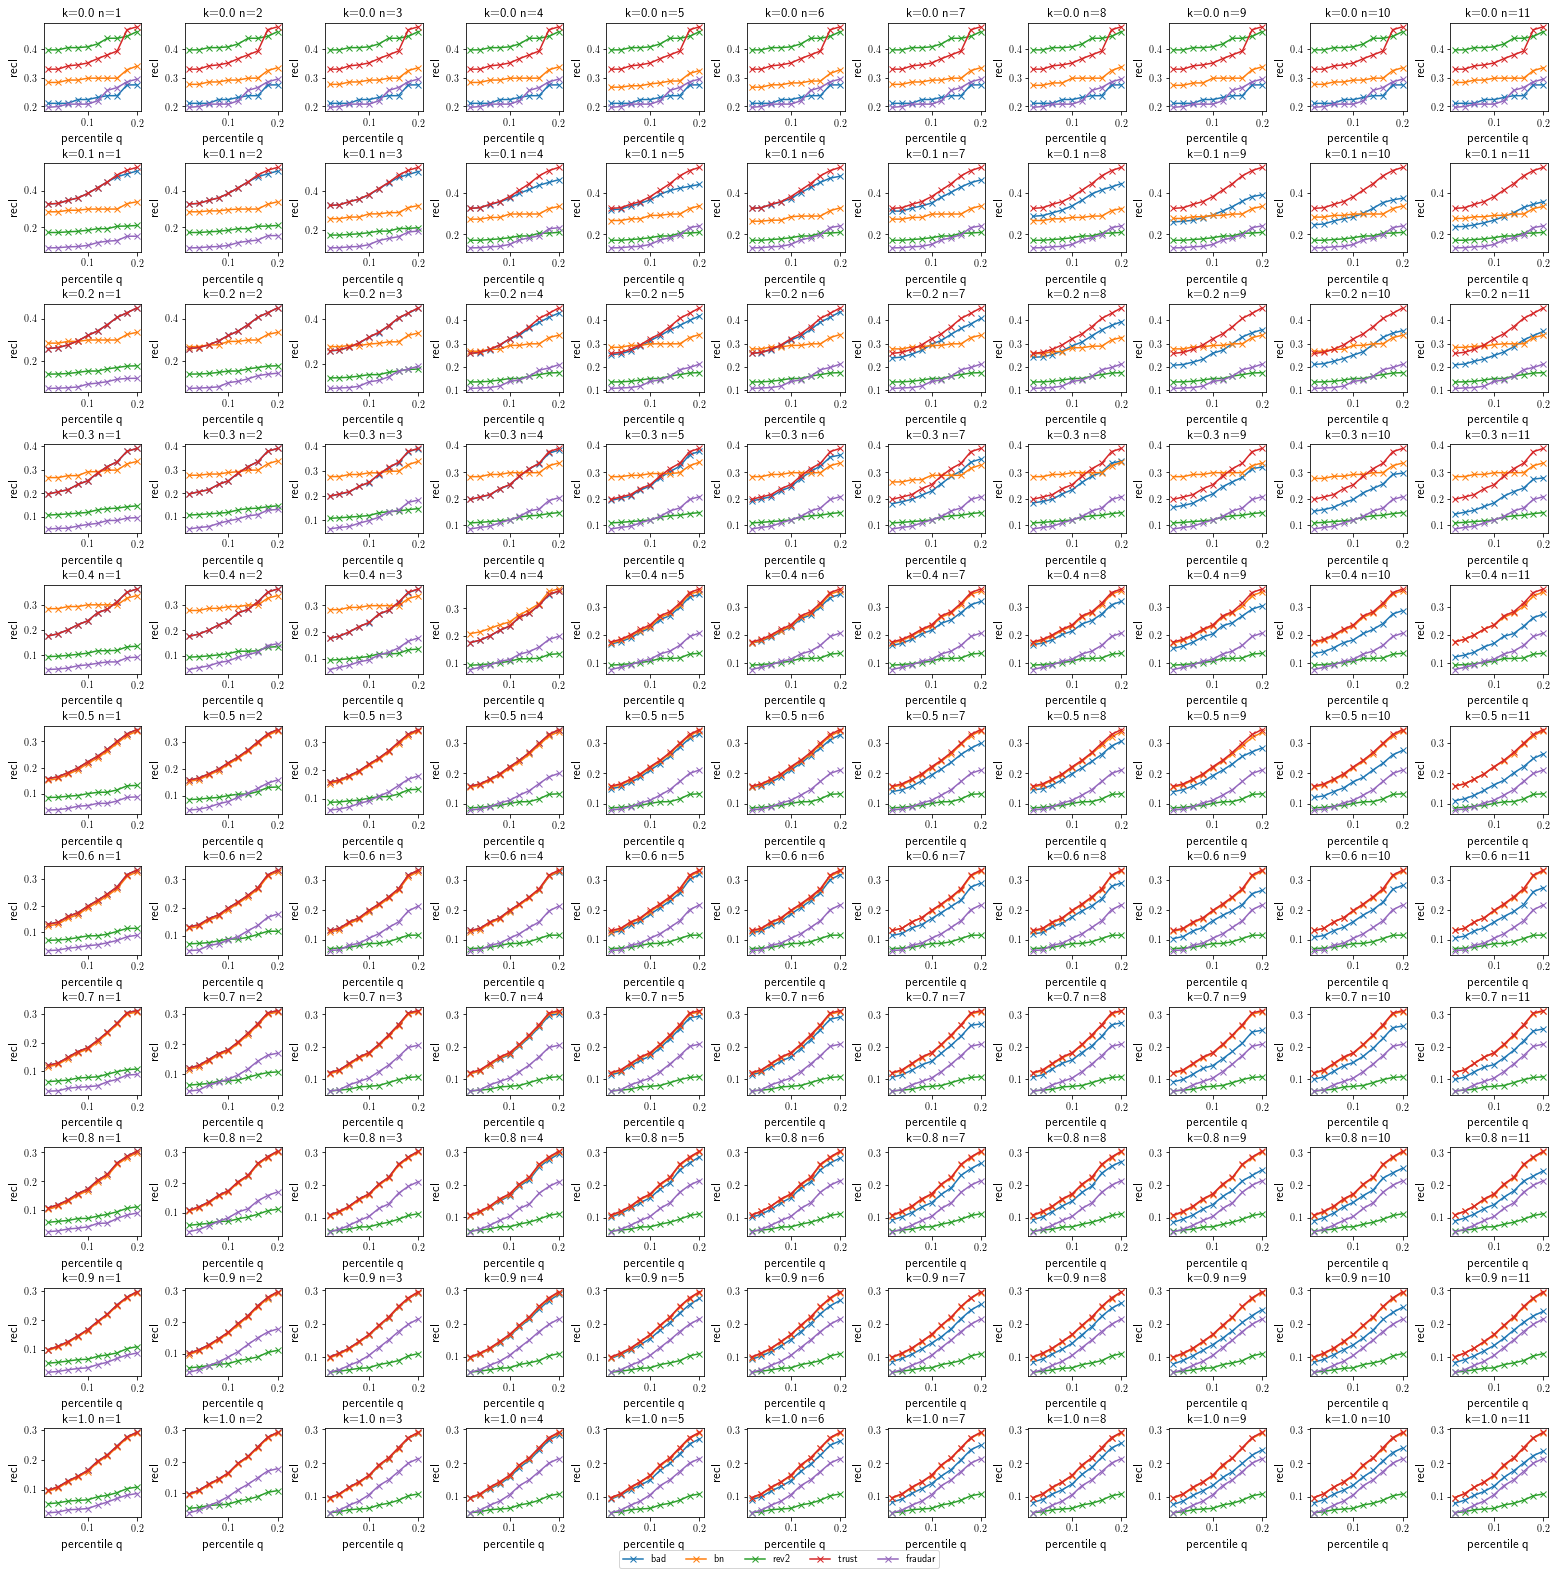

In [9]:
fig_recl, axes = plt.subplots(11, 11, figsize=(22, 22))
m = 'recl'

for k, n in itertools.product(range(11), range(11)):
    y_data = {}
    for alg_name in alg_list:
        y_data[alg_name] = [np.mean([plot_data_dict[alg_name][(k, n, ind)][m][qq] for ind in range(50)]) for qq in q]
    lines = plot_lines(axes[k, n], q, y_data, xlabel='percentile q', ylabel=m, title='k=%.1f n=%d' %(k/10, n+1), e_data=None)
    
fig_recl.tight_layout(pad=2, w_pad=0.3, h_pad=0.2)
fig_recl.legend(lines, alg_list, loc='lower center', ncol=len(alg_list), fontsize='medium')

## Plot f1 score for each k, n pair

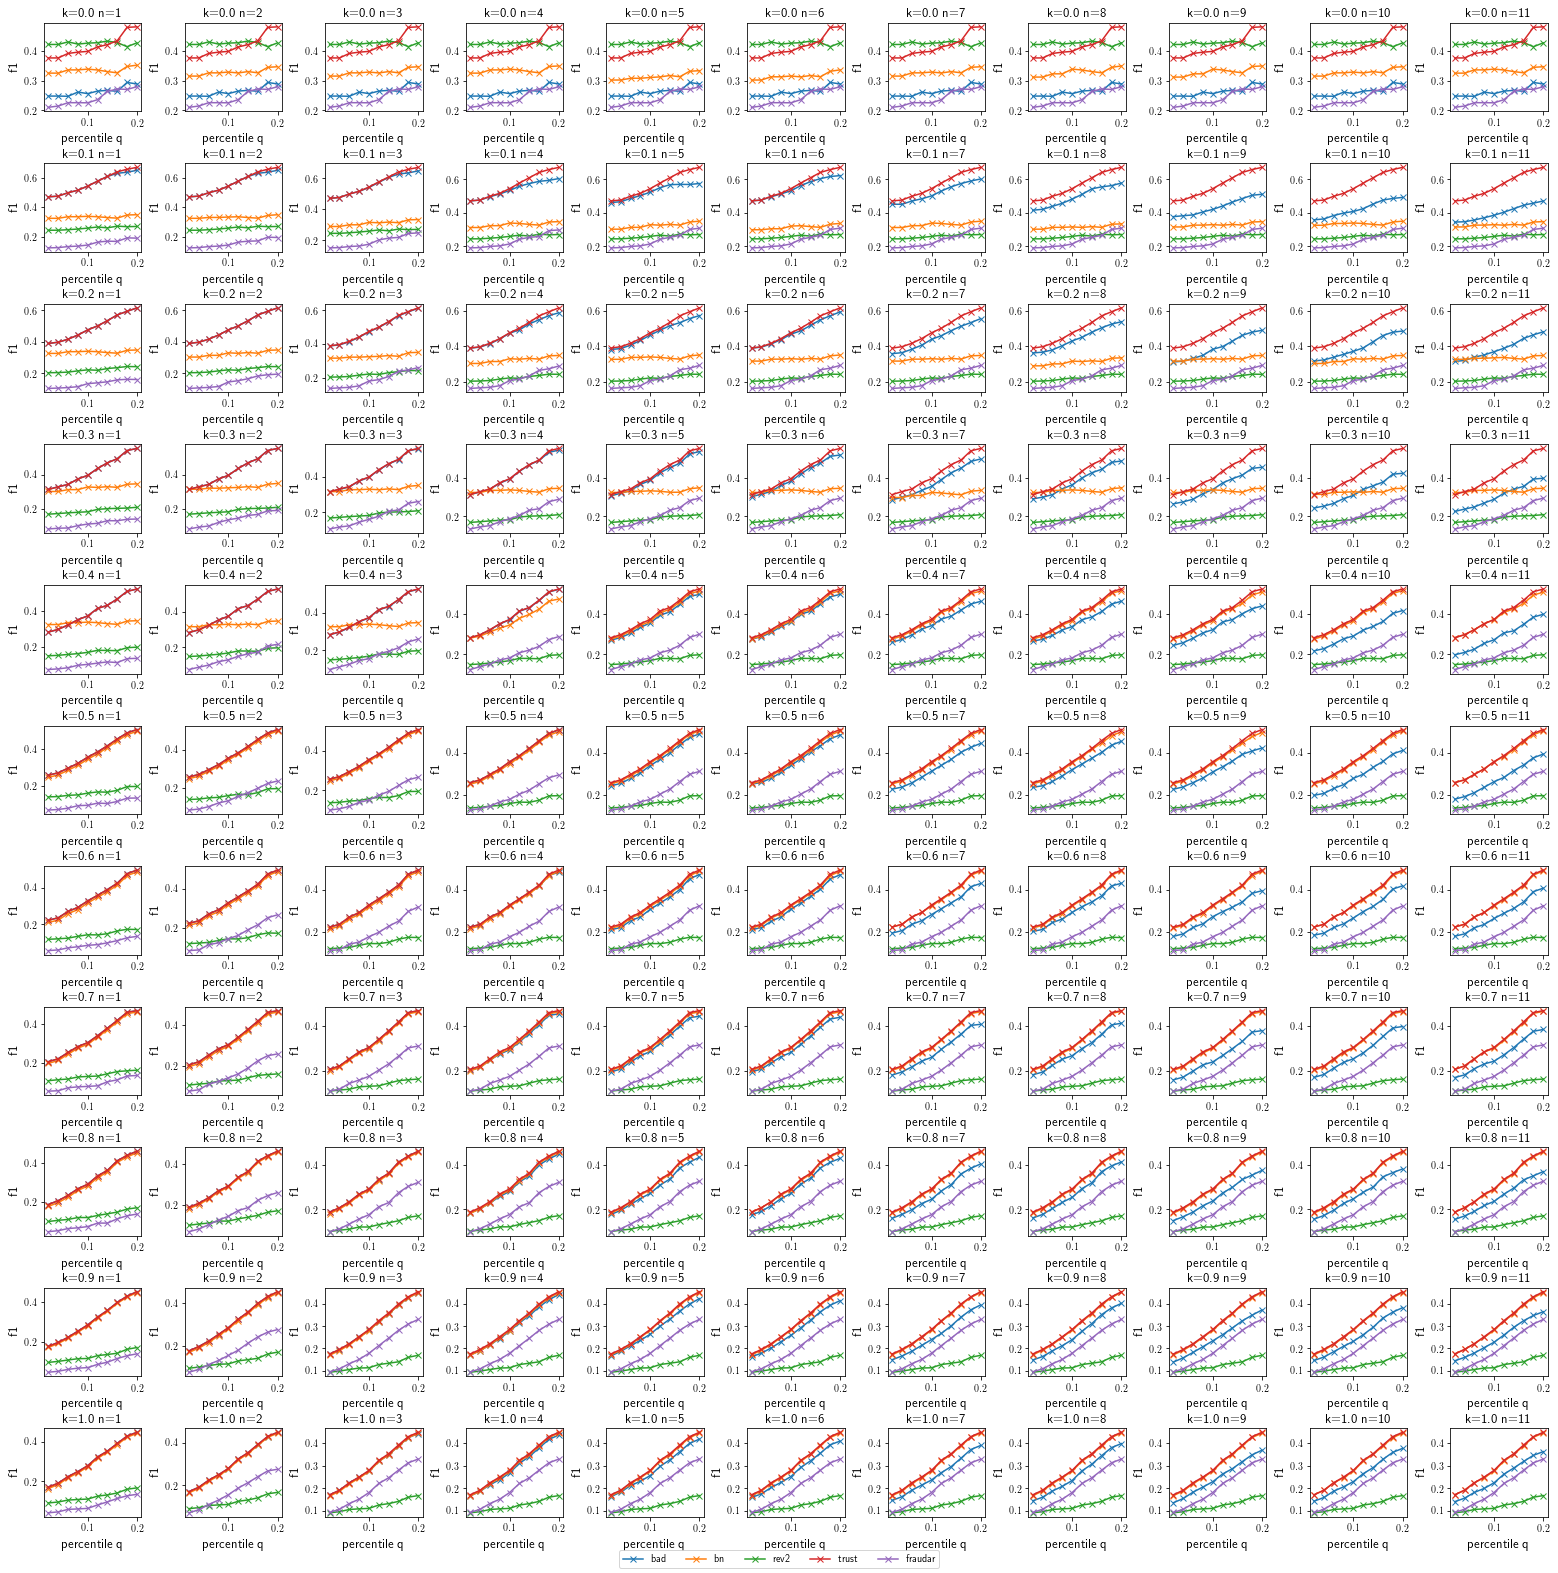

In [14]:
fig_f1, axes = plt.subplots(11, 11, figsize=(22, 22))
m = 'f1'

for k, n in itertools.product(range(11), range(11)):
    y_data = {}
    for alg_name in alg_list:
        y_data[alg_name] = [np.mean([plot_data_dict[alg_name][(k, n, ind)][m][qq] for ind in range(50)]) for qq in q]
    lines = plot_lines(axes[k, n], q, y_data, xlabel='percentile q', ylabel=m, title='k=%.1f n=%d' %(k/10, n+1), e_data=None)
    
fig_f1.tight_layout(pad=2, w_pad=0.3, h_pad=0.2)
fig_f1.legend(lines, alg_list, loc='lower center', ncol=len(alg_list), fontsize='medium')

In [15]:
fig_prec.savefig('../figures/%s-prec.pdf' %data_name)
fig_recl.savefig('../figures/%s-recl.pdf' %data_name)
fig_f1.savefig('../figures/%s-f1.pdf' %data_name)